In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
from scipy import stats
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.stats.weightstats import DescrStatsW
import astropy.units as u
from scipy.interpolate import interp1d

In [10]:
targets = pd.read_csv('./correct_unassociated/FERMILTRNSUnassociated.csv')

# Collect files
datasets = glob.glob('./correct_unassociated/apjsac*.csv')

# Track SRCNumber
filename = []
filenumber = []

library = {} # key = filename, val = pd.DataFrame
for file in datasets:
    # Read in data for each file
    library[file] = pd.read_csv(file, header=None)
    
    # Track SRCNumber
    filename.append(file)
    filenumber.append( int(file.split('_')[2]) )

# Create pd for file:SRCNumbers
filename_to_filenumber = pd.DataFrame({'filename': filename, 'filenumber': filenumber})

In [11]:
# Merge datasets on IMG file number
targets = targets.merge(right = filename_to_filenumber, how = 'outer', left_on = 'IMG_NUMBER', right_on = 'filenumber')

In [12]:
# Reformat datasets
def reformat_datasets(library):
    reformat = {}

    for key in library:

        # For each dataset
        d = library[key]
        x = []
        y = []
        yerr = []
        # For each row
        for i in range(d.shape[0]):
            # Odds are data, evens are upper/lower error bound
            if i % 2:
                yerr.append(d.iloc[i,1])
            else:
                x.append(d.iloc[i,0])
                y.append(d.iloc[i,1])

        # Make error always positive
        yerr = np.abs(np.array(y) - np.array(yerr))

        # Reformat pd appropriately
        reformat[key] = pd.DataFrame( {'MJD':x, 'Fl (E>100MeV)e-8 cm-2 s-1':y, 'Error':yerr} )

    return reformat

library = reformat_datasets(library)



In [15]:
seconds_in_a_day = 8.64e4

distance_A = lambda A: np.sqrt(3.2 / A)


invert_distance_to_A = lambda d: 3.2/d**2
#f"{invert_distance_to_A(.3e-1):.1e}"
f"{invert_distance_to_A(1e-6):.1e}"




'3.2e+12'

In [43]:
fit_results

{'./correct_unassociated/apjsac072af17_91_hr.csv': (array([ 9.65752991, 16.53964184]),
  array([[8.97971228e+15, 1.69428587e+16],
         [1.69428587e+16, 3.19676681e+16]])),
 './correct_unassociated/apjsac072af17_122_hr.csv': (array([ 9.61182027, 16.61029729]),
  array([[2.55235921e+16, 4.81577362e+16],
         [4.81577362e+16, 9.08636819e+16]])),
 './correct_unassociated/apjsac072af17_13_hr.csv': (array([ 9.58567427, 16.65181933]),
  array([[5.52193040e+16, 1.04187399e+17],
         [1.04187399e+17, 1.96580060e+17]])),
 './correct_unassociated/apjsac072af17_62_hr.csv': (array([ 9.53316825, 16.73358011]),
  array([[7.88527915e+15, 1.48778899e+16],
         [1.48778899e+16, 2.80714992e+16]])),
 './correct_unassociated/apjsac072af17_130_hr.csv': (array([ 9.61341758, 16.61394806]),
  array([[3.95321724e+16, 7.45890280e+16],
         [7.45890280e+16, 1.40734060e+17]])),
 './correct_unassociated/apjsac072af17_29_hr.csv': (array([ 9.54055841, 16.72213926]),
  array([[3.83341668e+16, 7.232

Running ./correct_unassociated/apjsac072af17_91_hr.csv [1/35]
Running ./correct_unassociated/apjsac072af17_122_hr.csv [3/35]
Running ./correct_unassociated/apjsac072af17_13_hr.csv [4/35]
Running ./correct_unassociated/apjsac072af17_62_hr.csv [5/35]
Running ./correct_unassociated/apjsac072af17_130_hr.csv [6/35]
Running ./correct_unassociated/apjsac072af17_29_hr.csv [7/35]
Running ./correct_unassociated/apjsac072af17_25_hr.csv [8/35]
Running ./correct_unassociated/apjsac072af17_27_hr.csv [9/35]
Running ./correct_unassociated/apjsac072af17_108_hr.csv [10/35]
Running ./correct_unassociated/apjsac072af17_44_hr.csv [11/35]
Running ./correct_unassociated/apjsac072af17_48_hr.csv [12/35]
Running ./correct_unassociated/apjsac072af17_56_hr.csv [13/35]
Running ./correct_unassociated/apjsac072af17_104_hr.csv [14/35]
Running ./correct_unassociated/apjsac072af17_6_hr.csv [15/35]
Running ./correct_unassociated/apjsac072af17_100_hr.csv [16/35]
Running ./correct_unassociated/apjsac072af17_112_hr.csv [18

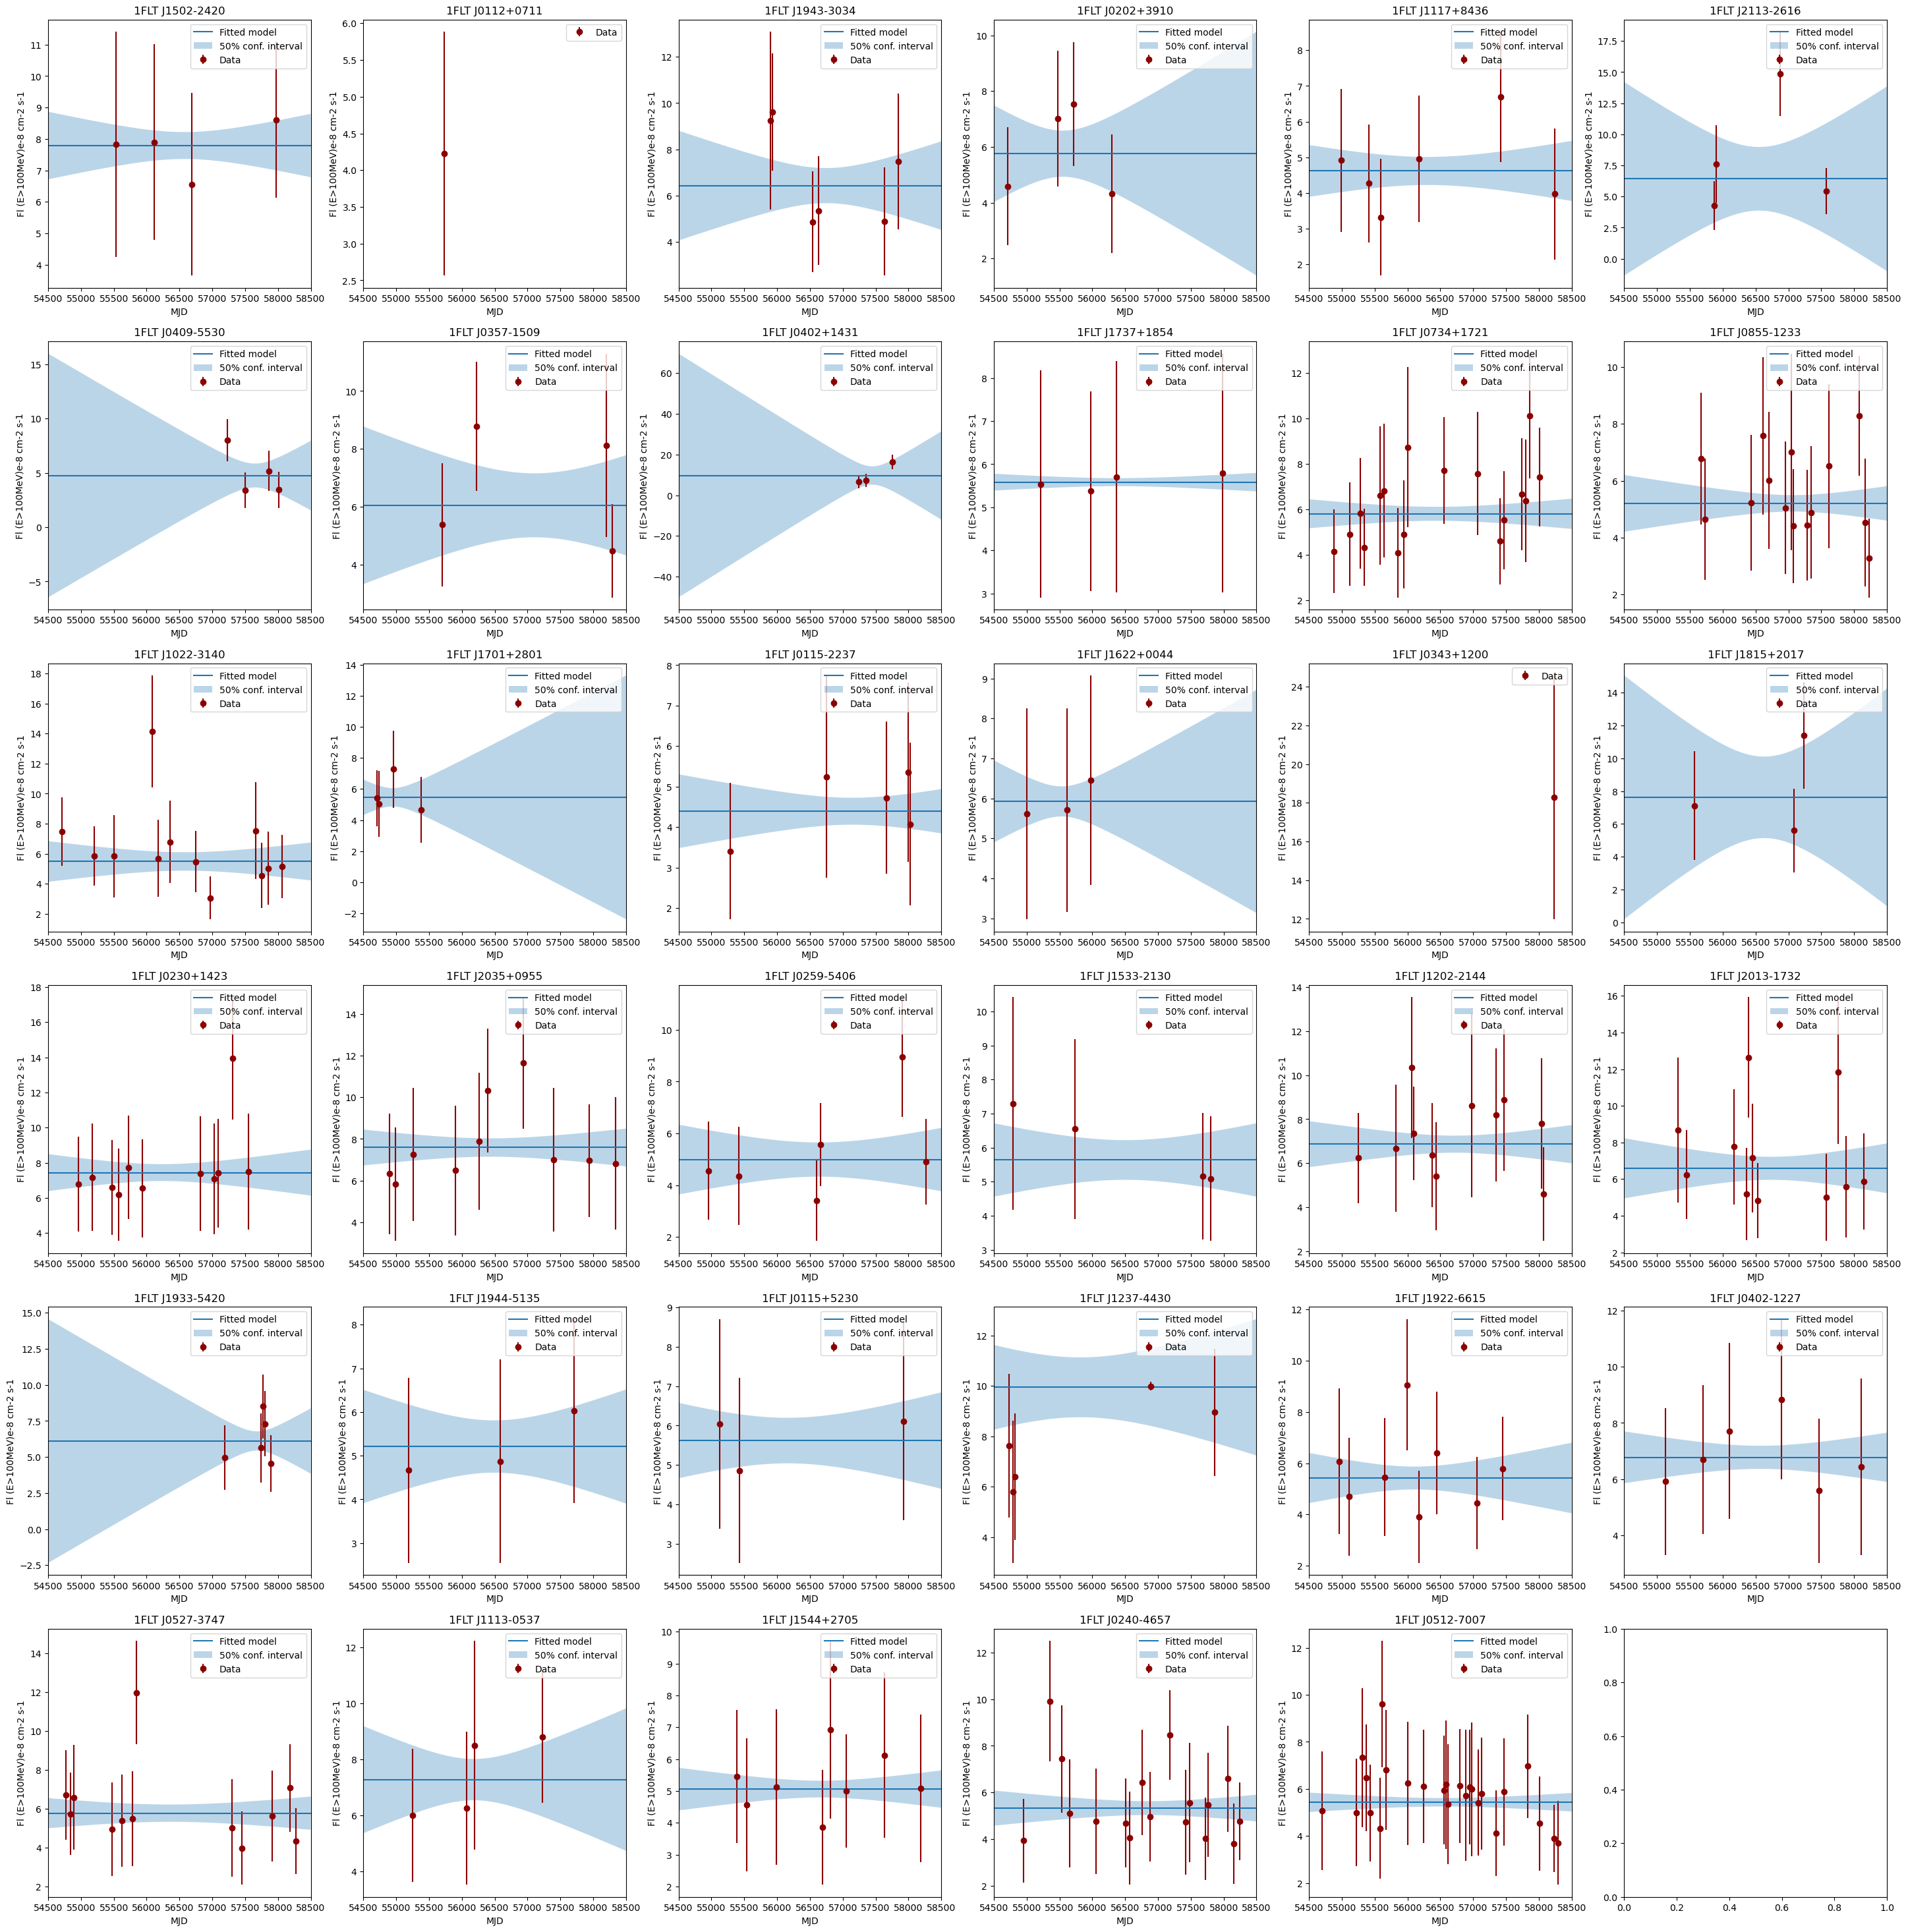

In [42]:
log_model = lambda x,A,T0: 10**A * ((10**T0) - x)**(-.53) # Assume T0 in MJD, so we want seconds

fig, axes = plt.subplots(6,6, figsize=(36,37))
ax = axes.flatten()

fit_results = {}

for i,key in enumerate(library):

    # Retrieve data
    d = library[key]
    x = d['MJD'].to_numpy()
    y = d['Fl (E>100MeV)e-8 cm-2 s-1'].to_numpy()
    yerr = d['Error'].to_numpy()

    # Plot datapoints
    ax[i].errorbar(x, y, yerr = yerr, fmt='o', color = 'darkred', label = 'Data')

    # More than 1 datapoint
    if x.shape[0] > 1:

        print(f'Running {key} [{i+1}/{len(library)}]')

        coefs, cov = curve_fit(f = log_model, xdata = x - x[0], ydata = y, sigma = yerr, 
            p0 = [
                10, 16
            ], bounds = (
                [3, np.log10(x[-1] - x[0])], # lower bounds
                [14, 27]  # upper bounds
            )
        )

        # Save fit results
        fit_results[key] = (coefs, cov)

        # Unpack results
        stds = np.sqrt(np.diagonal(cov))

        # Plot best model
        xinterval = np.linspace(54500, 58500) - x[0]
        y_model = log_model( xinterval, *coefs )
        ax[i].plot(xinterval + x[0], y_model, '-', label = 'Fitted model')

        # Calculate confidence interval
        n = len(y)
        p = len(coefs)
        dof = max(0, n - p)  # degrees of freedom
        t = stats.t.ppf(.5 / 2., dof) # 50% confidence interval

        s_err = np.sum(np.power(y - log_model(x - x[0], *coefs), 2))
        mean_x = np.mean(x - x[0])
        
        confs = t * np.sqrt(
            ( s_err / dof) * 
            (1.0/ n + 
                (np.power( (xinterval - mean_x) ,2) /
                    ( (np.sum(np.power(x - x[0],2))) - n*(np.power(mean_x,2)) )
                )
            )
            )

        ax[i].fill_between(xinterval + x[0], y_model - np.abs(confs), y_model + np.abs(confs), alpha=0.3, label=r'50% conf. interval')

    
    # Settings
    ax[i].set_xlim(54500, 58500)
    ax[i].set_xlabel('MJD')
    ax[i].set_ylabel('Fl (E>100MeV)e-8 cm-2 s-1')
    ax[i].set_title(targets.query('filename == @key').iloc[0].NAME[2:-1])
    ax[i].legend()
    

    

In [14]:
import ultranest

param_names = ['distance', 'T0']

class Ultranest_fitting_class:
    
    def __init__(self, x, y, yerr):
        self.x = x
        self.y = y
        self.yerr = yerr

    def gaussian_likelihood(self, params):
        dist, T0 = params
        # compare model and data with gaussian likelihood:
        return -0.5 * (
            (
                (
                    self.model((self.x - self.x[0]), dist, T0) - self.y
                ) / self.yerr
            )**2
            ).sum()

    def prior(self, cube):
        params = cube.copy()

        # distance: log-uniform prior
        lo = -10
        hi = -4
        params[0] = np.float_power( 10, (cube[0] * (hi - lo) + lo) )

        # T0: log-uniform prior
        lo = np.log10(self.x[-1] - self.x[0]) # IN MJD
        hi = 25
        params[1] = np.float_power( 10, (cube[1] * (hi - lo) + lo) )

        return params

    def model(self, x, distance, T0, beta = -.53):
        norm = 3.2 / np.float_power(distance,2) # Includes 1e-8 due to y-axis adjust
        return norm * np.float_power(T0 - x, beta)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
def model(x, distance, T0, beta = -.53):
    norm = 3.2 / np.float_power(distance,2) # Includes 1e-8 due to y-axis adjust
    return norm * np.float_power(T0 - x, beta)

xaxis = np.linspace(54500, 57500) - 54500
plt.plot(xaxis, model(xaxis, 0.000017, 332880554228301791494144))

TypeError: ufunc 'float_power' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Running ./correct_unassociated/apjsac072af17_91_hr.csv [0/35]
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-0.1  [-0.1460..-0.1460]*| it/evals=3160/4182 eff=83.5537% N=400    00 0 0 0 0    
[ultranest] Likelihood function evaluations: 4195
[ultranest]   logZ = -4.757 +- 0.08315
[ultranest] Effective samples strategy satisfied (ESS = 1256.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.08 tail:0.04 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -4.754 +- 0.159
  single instance: logZ = -4.754 +- 0.101
  bootstrapped   : logZ = -4.757 +- 0.155
  tail           : logZ = +- 0.036
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000017 +- 0.000024
    T0                  : 2434  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁  ▁▁▁▁▁│9999502338437948293251072    33288055422830

[ultranest] Explored until L=-2  1 [-1.7096..-1.7096]*| it/evals=3360/4392 eff=84.1683% N=400      N=400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4420
[ultranest]   logZ = -6.758 +- 0.07258
[ultranest] Effective samples strategy satisfied (ESS = 1292.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.07 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -6.757 +- 0.144
  single instance: logZ = -6.757 +- 0.106
  bootstrapped   : logZ = -6.758 +- 0.141
  tail           : logZ = +- 0.032
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000024
    T0                  : 1948  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│9999500112813050436780032    4336168216

[ultranest] Explored until L=-0.8  [-0.8375..-0.8374]*| it/evals=3179/4144 eff=84.9092% N=400    400 0 0 0    
[ultranest] Likelihood function evaluations: 4147
[ultranest]   logZ = -5.526 +- 0.0683
[ultranest] Effective samples strategy satisfied (ESS = 1308.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.04 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -5.539 +- 0.211
  single instance: logZ = -5.539 +- 0.102
  bootstrapped   : logZ = -5.526 +- 0.208
  tail           : logZ = +- 0.038
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000022
    T0                  : 1582  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁│9999498029947002868989952    4432859449341173

[ultranest] Explored until L=-1  8 [-1.0824..-1.0824]*| it/evals=3320/4417 eff=82.6487% N=400      N=400 0 0 0 0  
[ultranest] Likelihood function evaluations: 4423
[ultranest]   logZ = -6.035 +- 0.1031
[ultranest] Effective samples strategy satisfied (ESS = 1243.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.10 tail:0.03 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -6.028 +- 0.250
  single instance: logZ = -6.028 +- 0.106
  bootstrapped   : logZ = -6.035 +- 0.247
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 3256  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁ ▁│9999505247488678775750656    442611545501

[ultranest] Explored until L=-4  5 [-3.9556..-3.9556]*| it/evals=3200/4268 eff=82.7301% N=400    400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4283
[ultranest]   logZ = -8.619 +- 0.07252
[ultranest] Effective samples strategy satisfied (ESS = 1268.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -8.632 +- 0.213
  single instance: logZ = -8.632 +- 0.102
  bootstrapped   : logZ = -8.619 +- 0.210
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 1704  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁ ▁▁▁▁▁│9999498773495336040136704    40993985486212

[ultranest] Explored until L=-2  9 [-2.0905..-2.0905]*| it/evals=3360/4402 eff=83.9580% N=400    =400 0 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4411
[ultranest]   logZ = -7.006 +- 0.06458
[ultranest] Effective samples strategy satisfied (ESS = 1282.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.06 tail:0.03 total:0.07 required:<0.50
[ultranest] done iterating.

logZ = -7.000 +- 0.158
  single instance: logZ = -7.000 +- 0.105
  bootstrapped   : logZ = -7.006 +- 0.155
  tail           : logZ = +- 0.029
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000017 +- 0.000023
    T0                  : 788   │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ │9852860172869103295397888    38032176316

[ultranest] Explored until L=-1  8 [-1.4822..-1.4822]*| it/evals=3240/4257 eff=84.0031% N=400  0 =400 0 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4292
[ultranest]   logZ = -6.284 +- 0.07011
[ultranest] Effective samples strategy satisfied (ESS = 1265.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -6.302 +- 0.211
  single instance: logZ = -6.302 +- 0.104
  bootstrapped   : logZ = -6.284 +- 0.209
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000022
    T0                  : 2586  │▇▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁ ▁ │9999502945053328826957824    36529727057

[ultranest] Explored until L=-3  4 [-2.5365..-2.5365]*| it/evals=3240/4280 eff=83.5052% N=400    400   0 0 0    
[ultranest] Likelihood function evaluations: 4318
[ultranest]   logZ = -7.341 +- 0.0723
[ultranest] Effective samples strategy satisfied (ESS = 1300.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -7.348 +- 0.187
  single instance: logZ = -7.348 +- 0.103
  bootstrapped   : logZ = -7.341 +- 0.184
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 516   │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁ │9999486831618528649412608    37754030811537

[ultranest] Explored until L=-0.008  0.0091..-0.0091]*| it/evals=3120/4186 eff=82.4089% N=400  N=400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4211
[ultranest]   logZ = -4.495 +- 0.08606
[ultranest] Effective samples strategy satisfied (ESS = 1304.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.09 tail:0.03 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -4.515 +- 0.186
  single instance: logZ = -4.515 +- 0.099
  bootstrapped   : logZ = -4.495 +- 0.182
  tail           : logZ = +- 0.035
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000023
    T0                  : 2770  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│9999503630413702769934336    46406125183387

[ultranest] Explored until L=-4  9 [-4.0941..-4.0941]*| it/evals=3440/4692 eff=80.1491% N=400      N=400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4717
[ultranest]   logZ = -9.504 +- 0.07678
[ultranest] Effective samples strategy satisfied (ESS = 1258.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.04 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -9.489 +- 0.174
  single instance: logZ = -9.489 +- 0.111
  bootstrapped   : logZ = -9.504 +- 0.170
  tail           : logZ = +- 0.038
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000023
    T0                  : 3133  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁ ▁▁▁▁ ▁▁▁▁▁▁│9999504864118267994701824    3327086145

[ultranest] Explored until L=-3  7 [-3.1743..-3.1743]*| it/evals=3360/4461 eff=82.7382% N=400    N=400 0 0 0 0 
[ultranest] Likelihood function evaluations: 4503
[ultranest]   logZ = -8.367 +- 0.08644
[ultranest] Effective samples strategy satisfied (ESS = 1212.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.09 tail:0.04 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -8.352 +- 0.134
  single instance: logZ = -8.352 +- 0.109
  bootstrapped   : logZ = -8.367 +- 0.129
  tail           : logZ = +- 0.036
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 2556  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁│9999502827944006050119680    37487416382804

[ultranest] Explored until L=-5  98 [-4.9857..-4.9857]*| it/evals=3440/4528 eff=83.3333% N=400    N=400 0 0 0 0 
[ultranest] Likelihood function evaluations: 4550
[ultranest]   logZ = -10.16 +- 0.08467
[ultranest] Effective samples strategy satisfied (ESS = 1264.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.03 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -10.175 +- 0.240
  single instance: logZ = -10.175 +- 0.108
  bootstrapped   : logZ = -10.160 +- 0.238
  tail           : logZ = +- 0.031
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000023
    T0                  : 3347  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁  ▁▁▁ ▁▁  ▁│9999505523853713851023360    4101957993

[ultranest] Explored until L=-0.4  [-0.3635..-0.3635]*| it/evals=3280/4470 eff=80.5897% N=400    =400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4472
[ultranest]   logZ = -5.224 +- 0.07573
[ultranest] Effective samples strategy satisfied (ESS = 1286.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.08 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -5.228 +- 0.155
  single instance: logZ = -5.228 +- 0.104
  bootstrapped   : logZ = -5.224 +- 0.151
  tail           : logZ = +- 0.035
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000022
    T0                  : 669   │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁ │9979650287756293185732608    4333968369369

[ultranest] Explored until L=-0.4  [-0.3539..-0.3539]*| it/evals=3200/4269 eff=82.7087% N=400    400 0 0 0 0   
[ultranest] Likelihood function evaluations: 4289
[ultranest]   logZ = -5.046 +- 0.09195
[ultranest] Effective samples strategy satisfied (ESS = 1347.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.09 tail:0.03 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -5.038 +- 0.242
  single instance: logZ = -5.038 +- 0.101
  bootstrapped   : logZ = -5.046 +- 0.239
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000024
    T0                  : 2739  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│9999503520009697967996928    37583393020310

[ultranest] Explored until L=-0.03  -0.0318..-0.0318]*| it/evals=3120/4150 eff=83.2000% N=400 0 2% N=400 0 0 0 0 
[ultranest] Likelihood function evaluations: 4158
[ultranest]   logZ = -4.489 +- 0.06922
[ultranest] Effective samples strategy satisfied (ESS = 1309.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -4.482 +- 0.144
  single instance: logZ = -4.482 +- 0.099
  bootstrapped   : logZ = -4.489 +- 0.140
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000014 +- 0.000022
    T0                  : 975   │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁│9999493190944679897595904    429418732530

[ultranest] Explored until L=-1  9 [-0.9960..-0.9960]*| it/evals=3120/4161 eff=82.9567% N=400   400 0 0 0 0 0  
[ultranest] Likelihood function evaluations: 4177
[ultranest]   logZ = -5.433 +- 0.06127
[ultranest] Effective samples strategy satisfied (ESS = 1296.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.06 tail:0.03 total:0.07 required:<0.50
[ultranest] done iterating.

logZ = -5.436 +- 0.135
  single instance: logZ = -5.436 +- 0.099
  bootstrapped   : logZ = -5.433 +- 0.131
  tail           : logZ = +- 0.033
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000022
    T0                  : 1674  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁ ▁│9999498592727055974006784    36337977590129

[ultranest] Explored until L=-2  1 [-2.0090..-2.0090]*| it/evals=3440/4548 eff=82.9315% N=400    =400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4559
[ultranest]   logZ = -7.314 +- 0.07894
[ultranest] Effective samples strategy satisfied (ESS = 1282.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.04 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -7.323 +- 0.185
  single instance: logZ = -7.323 +- 0.110
  bootstrapped   : logZ = -7.314 +- 0.182
  tail           : logZ = +- 0.036
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000022
    T0                  : 2584  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁│9999502937207462959251456    4163572333228

[ultranest] Explored until L=-2  8 [-1.6854..-1.6854]*| it/evals=3320/4374 eff=83.5430% N=400    % N=400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4408
[ultranest]   logZ = -6.986 +- 0.08332
[ultranest] Effective samples strategy satisfied (ESS = 1243.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.05 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -6.979 +- 0.152
  single instance: logZ = -6.979 +- 0.110
  bootstrapped   : logZ = -6.986 +- 0.145
  tail           : logZ = +- 0.046
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000022
    T0                  : 3442  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁ ▁▁▁▁│9999505803049941975695360    3719641223

[ultranest] Explored until L=-2  3 [-2.1269..-2.1269]*| it/evals=3200/4261 eff=82.8801% N=400      % N=400 0 0 0  
[ultranest] Likelihood function evaluations: 4300
[ultranest]   logZ = -6.979 +- 0.07499
[ultranest] Effective samples strategy satisfied (ESS = 1252.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.04 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -6.956 +- 0.116
  single instance: logZ = -6.956 +- 0.104
  bootstrapped   : logZ = -6.979 +- 0.110
  tail           : logZ = +- 0.038
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000024
    T0                  : 3314  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁ ▁▁ ▁▁ ▁ ▁ │9999505423857864358756352    38636747130

[ultranest] Explored until L=-0.3  [-0.2771..-0.2771]*| it/evals=3240/4343 eff=82.1709% N=400   0  N=400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4365
[ultranest]   logZ = -5.091 +- 0.07579
[ultranest] Effective samples strategy satisfied (ESS = 1298.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.08 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -5.087 +- 0.194
  single instance: logZ = -5.087 +- 0.103
  bootstrapped   : logZ = -5.091 +- 0.190
  tail           : logZ = +- 0.035
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000023
    T0                  : 3014  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁ ▁ │9999504475826853337104384    4272005667

[ultranest] Explored until L=-2  6 [-1.8578..-1.8578]*| it/evals=3440/4583 eff=82.2376% N=400    400 0 0 0 0 0  
[ultranest] Likelihood function evaluations: 4612
[ultranest]   logZ = -7.175 +- 0.07033
[ultranest] Effective samples strategy satisfied (ESS = 1263.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.07 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -7.154 +- 0.124
  single instance: logZ = -7.154 +- 0.110
  bootstrapped   : logZ = -7.175 +- 0.119
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 2828  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁│9999503839063753028009984    4139555676803

[ultranest] Explored until L=-4  7 [-3.6754..-3.6754]*| it/evals=3410/4652 eff=80.1976% N=400    400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4655
[ultranest]   logZ = -8.697 +- 0.08237
[ultranest] Effective samples strategy satisfied (ESS = 1271.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.03 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -8.677 +- 0.176
  single instance: logZ = -8.677 +- 0.106
  bootstrapped   : logZ = -8.697 +- 0.173
  tail           : logZ = +- 0.029
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000024
    T0                  : 2828  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁│9999503839063753028009984    40866318992832

[ultranest] Explored until L=-1  9 [-1.1895..-1.1895]*| it/evals=3240/4323 eff=82.5899% N=400    =400  0 0 0  0 
[ultranest] Likelihood function evaluations: 4351
[ultranest]   logZ = -6.029 +- 0.06758
[ultranest] Effective samples strategy satisfied (ESS = 1270.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.04 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -6.038 +- 0.178
  single instance: logZ = -6.038 +- 0.104
  bootstrapped   : logZ = -6.029 +- 0.175
  tail           : logZ = +- 0.036
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 702   │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁ ▁▁▁│9999489907889230219051008    4359258853200

[ultranest] Explored until L=-0.1  [-0.1197..-0.1197]*| it/evals=3200/4205 eff=84.0999% N=400  N=400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4246
[ultranest]   logZ = -4.722 +- 0.07829
[ultranest] Effective samples strategy satisfied (ESS = 1310.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.08 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -4.716 +- 0.173
  single instance: logZ = -4.716 +- 0.100
  bootstrapped   : logZ = -4.722 +- 0.170
  tail           : logZ = +- 0.030
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁│0.000100    0.000016 +- 0.000023
    T0                  : 2527  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│9999502712964761566314496    47778482473190

[ultranest] Explored until L=-0.08  -0.0858..-0.0858]*| it/evals=3080/4020 eff=85.0829% N=400 400  0 0 0 00  0 
[ultranest] Likelihood function evaluations: 4059
[ultranest]   logZ = -4.483 +- 0.07746
[ultranest] Effective samples strategy satisfied (ESS = 1342.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.08 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -4.508 +- 0.226
  single instance: logZ = -4.508 +- 0.098
  bootstrapped   : logZ = -4.483 +- 0.223
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 2802  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁ ▁▁▁▁▁▁│9999503744966860728172544    45581255644603

[ultranest] Explored until L=-3  3 [-2.5297..-2.5297]*| it/evals=4160/5433 eff=82.6545% N=400         0  00 0 0 0 0 
[ultranest] Likelihood function evaluations: 5453
[ultranest]   logZ = -9.6 +- 0.1002
[ultranest] Effective samples strategy satisfied (ESS = 1254.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.10 tail:0.03 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -9.613 +- 0.193
  single instance: logZ = -9.613 +- 0.129
  bootstrapped   : logZ = -9.600 +- 0.190
  tail           : logZ = +- 0.034
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 3133  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁▁▁▁ │9990240784622909216784384    417320113357

[ultranest] Explored until L=-2  8 [-1.6822..-1.6821]*| it/evals=3360/4354 eff=84.9772% N=400    N=400 0 0 0 0 
[ultranest] Likelihood function evaluations: 4391
[ultranest]   logZ = -6.851 +- 0.09118
[ultranest] Effective samples strategy satisfied (ESS = 1274.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.09 tail:0.04 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -6.868 +- 0.204
  single instance: logZ = -6.868 +- 0.108
  bootstrapped   : logZ = -6.851 +- 0.200
  tail           : logZ = +- 0.037
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000024
    T0                  : 2492  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁▁▁ │9999502575056926514610176    40110345968991

[ultranest] Explored until L=-0.5  [-0.4737..-0.4737]*| it/evals=3160/4227 eff=82.5712% N=400 0  =400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4243
[ultranest]   logZ = -5.262 +- 0.0657
[ultranest] Effective samples strategy satisfied (ESS = 1285.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.11 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.04 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -5.246 +- 0.111
  single instance: logZ = -5.246 +- 0.103
  bootstrapped   : logZ = -5.262 +- 0.103
  tail           : logZ = +- 0.041
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000024
    T0                  : 2983  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│9999504373974641670094848    39624206284502

[ultranest] Explored until L=-4  6 [-3.9605..-3.9605]*| it/evals=3440/4512 eff=83.6576% N=400       0 0 0 
[ultranest] Likelihood function evaluations: 4551
[ultranest]   logZ = -9.328 +- 0.09609
[ultranest] Effective samples strategy satisfied (ESS = 1265.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.10 tail:0.04 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -9.329 +- 0.229
  single instance: logZ = -9.329 +- 0.110
  bootstrapped   : logZ = -9.328 +- 0.226
  tail           : logZ = +- 0.036
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 3502  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁▁▁▁▁ │9999505977717938257395712    4120458493703219388

[ultranest] Explored until L=-0.5  [-0.4796..-0.4796]*| it/evals=3360/4448 eff=83.0040% N=400    =400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4474
[ultranest]   logZ = -5.443 +- 0.0742
[ultranest] Effective samples strategy satisfied (ESS = 1303.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.07 tail:0.03 total:0.08 required:<0.50
[ultranest] done iterating.

logZ = -5.442 +- 0.128
  single instance: logZ = -5.442 +- 0.105
  bootstrapped   : logZ = -5.443 +- 0.124
  tail           : logZ = +- 0.030
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 1976  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁│9999500254251020040798208    40080004106151

[ultranest] Explored until L=-0.6  [-0.5766..-0.5766]*| it/evals=3440/4492 eff=84.0665% N=400    0  0  0 0 
[ultranest] Likelihood function evaluations: 4521
[ultranest]   logZ = -5.854 +- 0.1015
[ultranest] Effective samples strategy satisfied (ESS = 1288.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.10 tail:0.03 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -5.847 +- 0.259
  single instance: logZ = -5.847 +- 0.109
  bootstrapped   : logZ = -5.854 +- 0.257
  tail           : logZ = +- 0.033
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ │0.000100    0.000015 +- 0.000023
    T0                  : 2800  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁▁▁▁▁▁▁ ▁│9999503740448544395362304    3896158574257281832

[ultranest] Explored until L=-5  98 [-4.9763..-4.9762]*| it/evals=3520/4613 eff=83.5509% N=400      0 0 0 0 
[ultranest] Likelihood function evaluations: 4651
[ultranest]   logZ = -10.59 +- 0.08971
[ultranest] Effective samples strategy satisfied (ESS = 1250.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.09 tail:0.04 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -10.590 +- 0.196
  single instance: logZ = -10.590 +- 0.113
  bootstrapped   : logZ = -10.585 +- 0.193
  tail           : logZ = +- 0.037
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000016 +- 0.000023
    T0                  : 3286  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁▁▁▁ │9999505340901737120137216    41970730173839

[ultranest] Explored until L=-4  9 [-3.7869..-3.7869]*| it/evals=3520/4607 eff=83.6701% N=400      N=400 0 0 0 0 0 
[ultranest] Likelihood function evaluations: 4643
[ultranest]   logZ = -9.495 +- 0.05694
[ultranest] Effective samples strategy satisfied (ESS = 1276.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.06 tail:0.04 total:0.07 required:<0.50
[ultranest] done iterating.

logZ = -9.510 +- 0.168
  single instance: logZ = -9.510 +- 0.114
  bootstrapped   : logZ = -9.495 +- 0.162
  tail           : logZ = +- 0.042
insert order U test : converged: True correlation: inf iterations

    distance            : 0.000000│▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁│0.000100    0.000015 +- 0.000023
    T0                  : 3591  │▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁▁ ▁ │9999506228109951031574528    4283362161

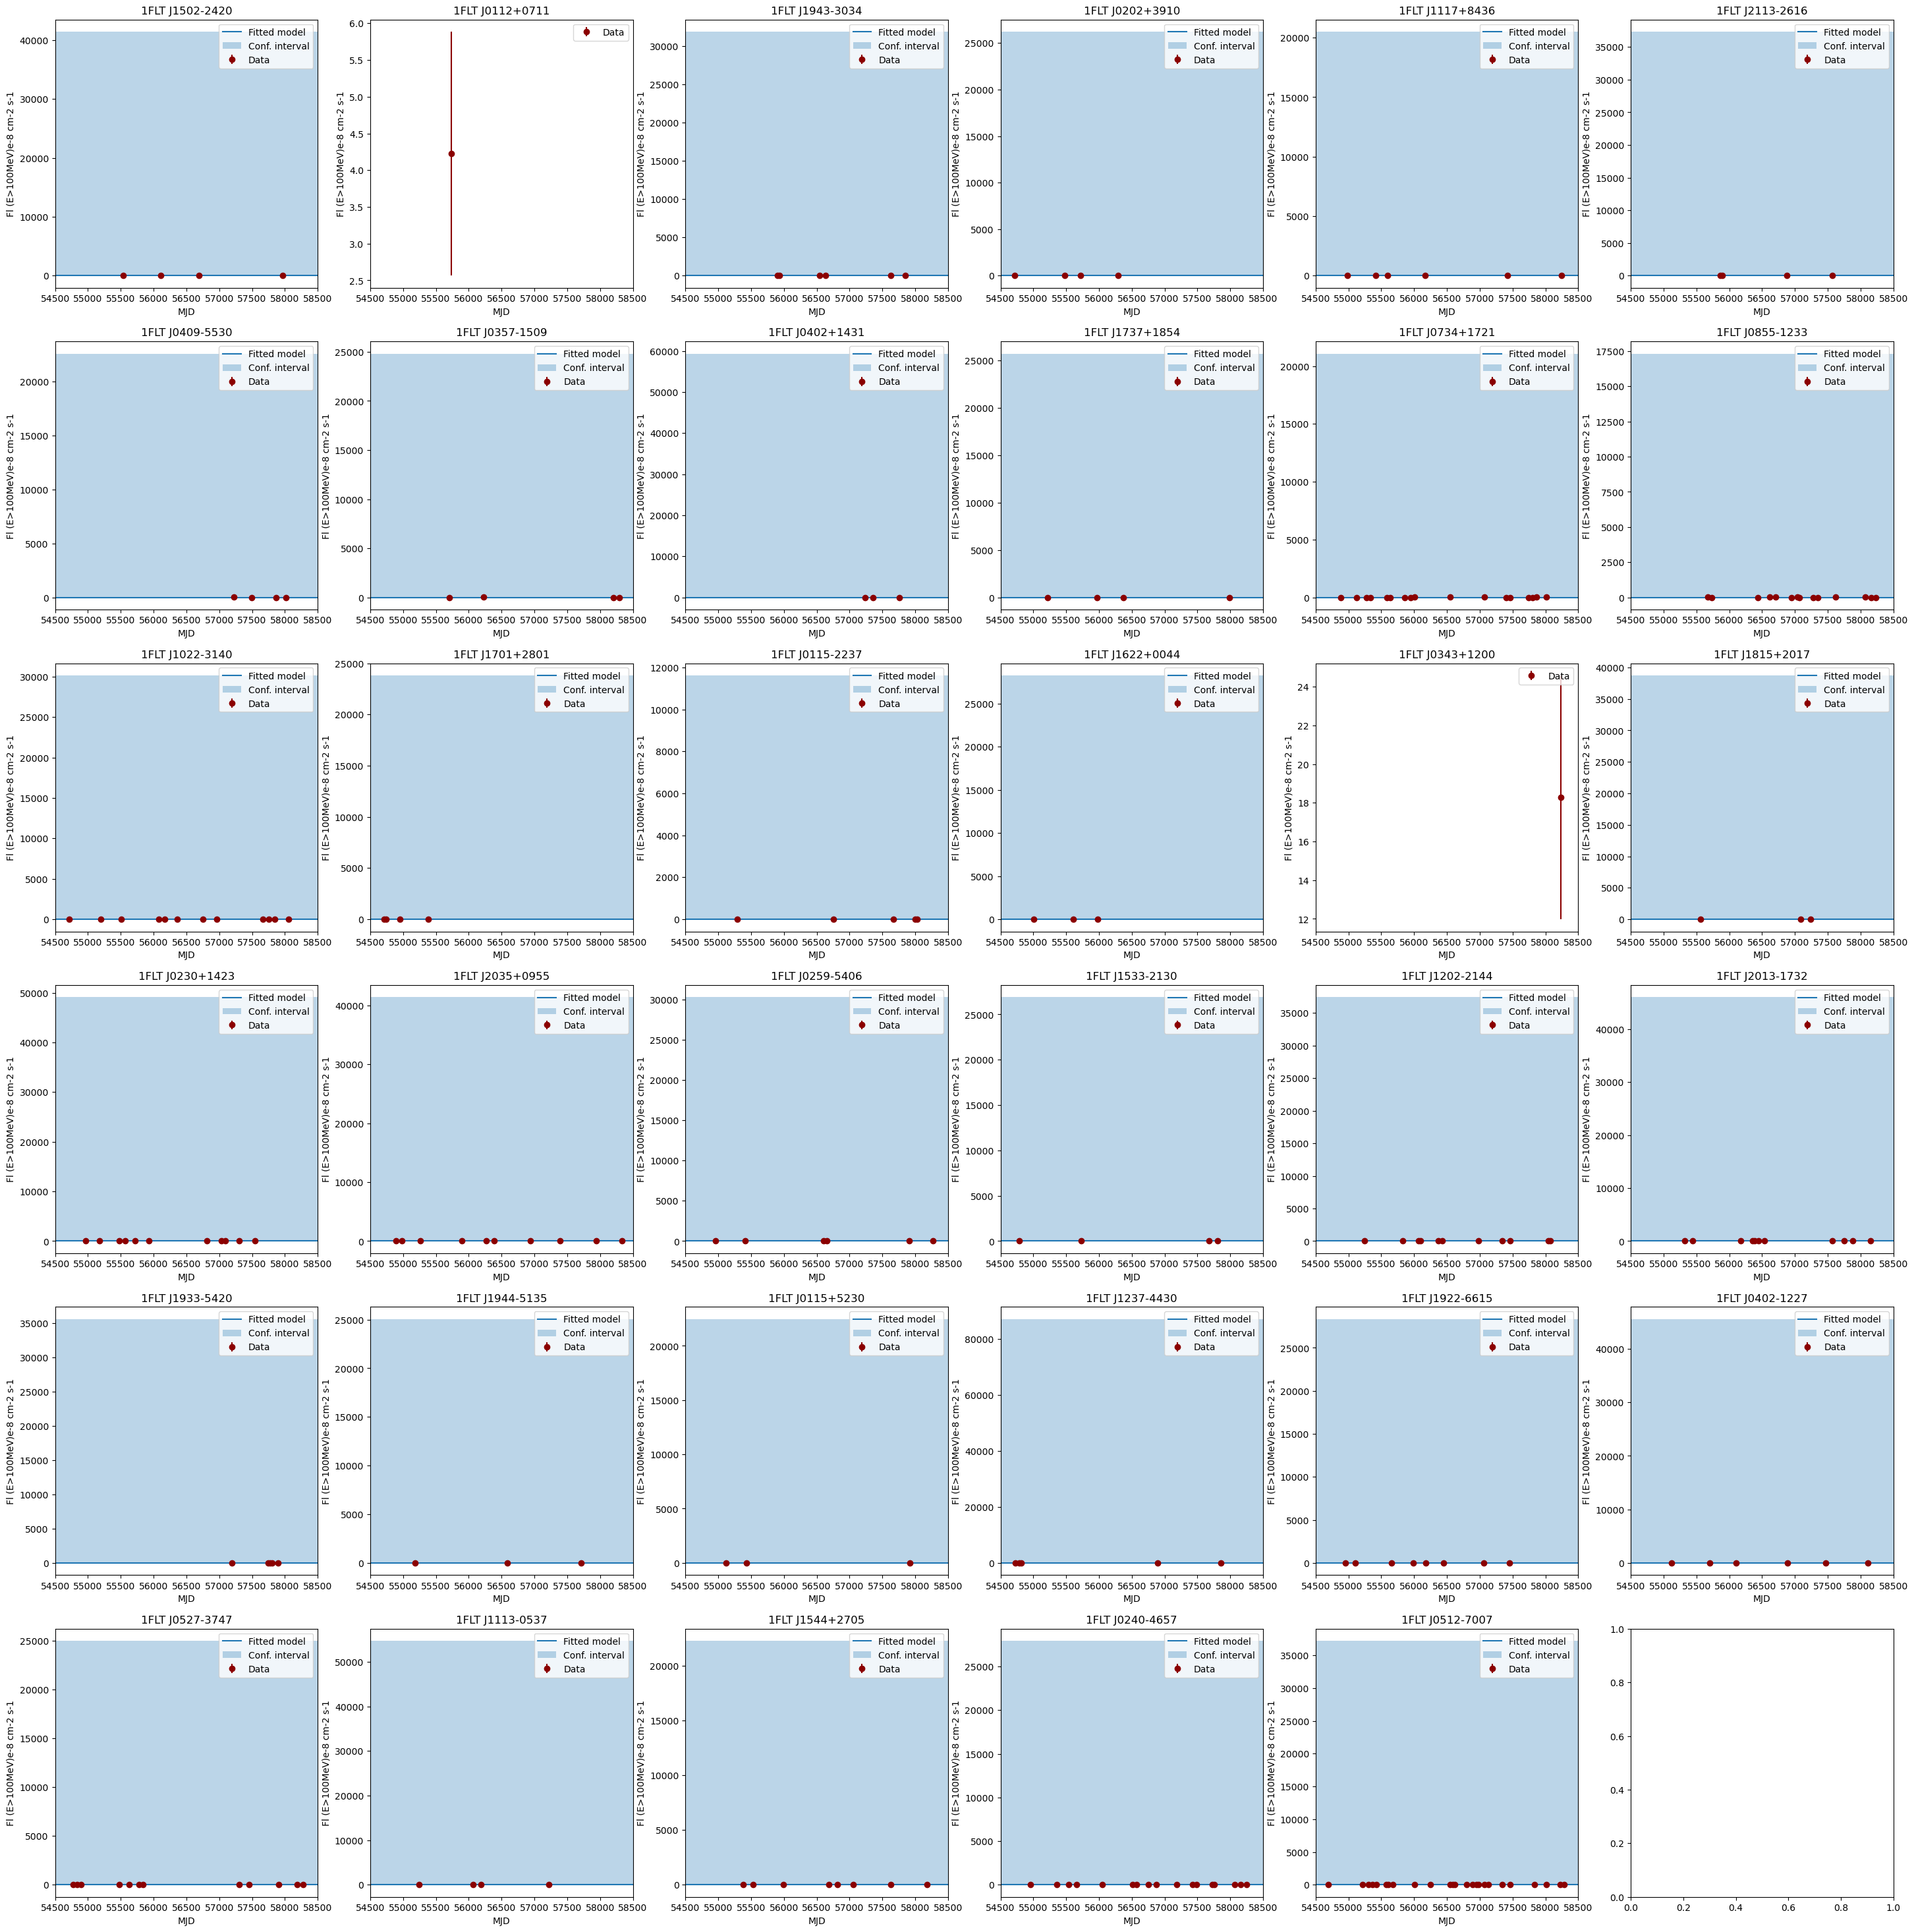

In [15]:
fig, axes = plt.subplots(6,6, figsize=(36,37))
ax = axes.flatten()

fit_results = {}

for i,key in enumerate(library):

    # Retrieve data
    d = library[key]
    x = d['MJD'].to_numpy()
    y = d['Fl (E>100MeV)e-8 cm-2 s-1'].to_numpy()
    yerr = d['Error'].to_numpy()

    # Plot datapoints
    ax[i].errorbar(x, y, yerr = yerr, fmt='o', color = 'darkred', label = 'Data')

    # More than 1 datapoint
    if x.shape[0] > 1:

        # Generate fitting info
        un_class = Ultranest_fitting_class(x, y, yerr)
        likelihood_fcn = un_class.gaussian_likelihood
        prior = un_class.prior
        model = un_class.model

        print(f'Running {key} [{i}/{len(library)}]')

        sampler = ultranest.ReactiveNestedSampler(param_names, likelihood_fcn, prior)

        # Fit
        result = sampler.run()
        sampler.print_results()

        # Save fit results
        fit_results[file] = result

        # Unpack results
        coefs = result['posterior']['mean']
        upper_error = result['posterior']['errup']
        lower_error = result['posterior']['errlo']

        # Save ylims
        ylims = ax[i].get_ylim()

        # Plot best model
        xaxis = np.linspace(54500, 58500)
        y_model = model( xaxis - x[0], *coefs )
        ax[i].plot(xaxis, y_model, '-', label = 'Fitted model')

        # Plot confidence intervals
        bounds = []
        for a in [lower_error[0], upper_error[0]]:
            for b in [lower_error[1], upper_error[1]]:
                bounds.append(model(xaxis - x[0], a, b))
                bounds.append(model(xaxis - x[0], a, b))
        upper_bound = np.vstack(bounds).max(axis=0)
        lower_bound = np.vstack(bounds).min(axis=0)

        ax[i].fill_between(xaxis, lower_bound, upper_bound, alpha=0.3, label='Conf. interval')
    
    # Settings
    ax[i].set_xlim(54500, 58500)
    ax[i].set_ylim(*ylims)
    ax[i].set_xlabel('MJD')
    ax[i].set_ylabel('Fl (E>100MeV)e-8 cm-2 s-1')
    ax[i].set_title(targets.query('filename == @key').iloc[0].NAME[2:-1])
    ax[i].legend()
    

    

In [138]:
log_model = lambda x,A,T0: 10**A * ((10**T0) - x)**(-.53) # Assume T0 in MJD, so we want seconds



fig, axes = plt.subplots(6,6, figsize=(36,37))
ax = axes.flatten()
loss_fig, loss_axes = plt.subplots(6,6, figsize=(36,37))
loss_ax = loss_axes.flatten()

fit_results = {}

ensemble_resolution = 100# 10000 models

for i,key in enumerate(library):

    d = library[key]

    x = d['MJD']
    y = d['Fl (E>100MeV)e-8 cm-2 s-1']
    yerr = d['Error']

    # T0 > range of data pts
    min_T0 = x.iloc[-1]-x.iloc[0]

    # Plot datapoints
    ax[i].errorbar(x, y, yerr = yerr, fmt='o', color = 'darkred', label = r'min. $T_0 = \Delta$MJD = %i'%(x.iloc[-1] - x.iloc[0]))
    
    # Curve fitting
    if x.shape[0]>1: # If there's >1 datapoint
        # coefs, cov = curve_fit(f = model, xdata = x, ydata = y, sigma = yerr, 
        # p0 = [
        #     10, 5
        # ], bounds = (
        #     [2, 3.6], # lower bounds
        #     [14, 24]  # upper bounds
        # )
        # )
        coef_track = []
        loss_track = []
        for T in np.linspace(np.log10(min_T0), 27, ensemble_resolution):
            for d in np.linspace(3, 14, ensemble_resolution):
                try:
                    coefs, cov = curve_fit(f = log_model, xdata = x - x.iloc[0], ydata = y, sigma = yerr, 
                    p0 = [
                        d, T
                    ], bounds = (
                        [3, np.log10(min_T0)], # lower bounds
                        [14, 27]  # upper bounds
                    )
                    )
                    loss = np.sum(
                        #[ 0 if np.abs(ydata - y[k]) < yerr[k] else (y[k] - ydata)**2 for k,ydata in enumerate(y_model) ]
                        [ 1-stats.norm.pdf(ydata, loc=y[k], scale=yerr[k])  for k,ydata in enumerate(log_model(x, *coefs)) ]
                    )
                    coef_track.append(coefs)
                    loss_track.append(loss)
                except:
                    print(f'{key}: skipping {d},{T}')
                    pass
        

        coef_track = np.array(coef_track)
        # Plot loss
        loss_ax[i].scatter(range(len(loss_track)), np.abs(loss_track))
        loss_ax[i].set_yscale('log')
        loss_ax[i].set_xscale('log')
        loss_ax[i].set_xlabel('Seed distance (pc)')
        loss_ax[i].set_ylabel('Absolute value of loss function')

        # Calculate errors
        index50 = np.where(
            loss_track <= np.quantile(loss_track, 0.5) # loss < 50pctile
            )[0]
        a = coef_track[:,0][index50]
        a_min = 10**a.min()
        a_max = 10**a.max()
        b = coef_track[:,1][index50]
        b_min = 10**b.min()
        b_max = 10**b.max()
        
        # Calculate best coefs (lowest loss)
        coefs = coef_track[np.where(loss_track == min(loss_track))[0][0]]
        loss = loss_track[np.where(loss_track == min(loss_track))[0][0]]

        # Plot the data and the fitted curve
        xaxis = np.linspace(54500, 58500)
        y_model = log_model(xaxis, coefs[0], coefs[1])

        # Calculate distance
        ax[i].plot(xaxis, y_model, '-', label = 'd = %.2epc\nT0 = %.2es\nL %.1e'%(distance_A(10**coefs[0]), 10**coefs[1]*seconds_in_a_day, loss)) # Note that T0 is in MJD -> s
        """
        # Compute std for each coef
        # a_err, b_err = 10**np.sqrt(np.diag(cov))

        # Compute the confidence interval for the fitted curve
        n = len(y)
        p = len(coefs)
        dof = max(0, n - p)  # degrees of freedom
        t = 1#stats.t.ppf(.5 / 2., dof) # 50% confidence interval

        # Sample standard deviation 
        # if (y - yerr) < model < (y + yerr): error is 0
        # otherwise base the error on the extreme of the errorbar i.e.
        # gaussian likelihood[ y + yerr - model() ]
        s_err = np.mean(#np.sqrt(
            #np.sum(np.array([ 0 if np.abs(ydata - y[k]) < yerr[k] else (y[k] - ydata)**2 for k,ydata in enumerate(model(x, *coefs)) ]) ) / dof
            [ 1-stats.norm.pdf(ydata, loc=y[k], scale=yerr[k])  for k,ydata in enumerate(model(x, *coefs)) ]
            )

        # https://www.scribbr.com/statistics/confidence-interval/
        # https://tomholderness.wordpress.com/2013/01/10/confidence_intervals/
        y_fit_upper = y_model + t * s_err * np.sqrt(1.0 + 1.0/n + (xaxis - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        y_fit_lower = y_model - t * s_err * np.sqrt(1.0 + 1.0/n + (xaxis - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

        ax[i].fill_between(xaxis, y_fit_lower, y_fit_upper, alpha=0.3, label='50pct conf. interval')
        """
        s_err = np.mean(#np.sqrt(
            #np.sum(np.array([ 0 if np.abs(ydata - y[k]) < yerr[k] else (y[k] - ydata)**2 for k,ydata in enumerate(model(x, *coefs)) ]) ) / dof
            [ 1-stats.norm.pdf(ydata, loc=y[k], scale=yerr[k])  for k,ydata in enumerate(log_model(x, *coefs)) ]
            )

        bounds = []
        for a in [a.min(), a.max()]:
            for b in [b.min(), b.max()]:
                bounds.append(log_model(xaxis, a, b))
                bounds.append(log_model(xaxis, a, b))
        upper_bound = np.vstack(bounds).max(axis=0)
        lower_bound = np.vstack(bounds).min(axis=0)

        ax[i].fill_between(xaxis, lower_bound, upper_bound, alpha=0.3, label='50pct conf. interval')


        fit_results[key] = {'Coefs':10**coefs, 'Serr':10**s_err, 'A_min':a_min, 'A_max':a_max, 'T0_min':b_min, 'T0_max':b_max}#'Cov':10**cov,

    ax[i].set_xlim(54500, 58500)

    ax[i].set_xlabel('MJD')
    ax[i].set_ylabel('Fl (E>100MeV)e-8 cm-2 s-1')
    ax[i].set_title(targets.query('filename == @key').iloc[0].NAME[2:-1])
    ax[i].legend()


# fig.savefig('TransientSourceFits_T0>>DeltaT.png', dpi=500)
# fig.savefig('TransientSourceFits_T0>>DeltaT_lowres.png')
# fig.savefig('TransientSourceFits_logsFit.png')

./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.0,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.111111111111111,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.2222222222222223,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.3333333333333335,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.4444444444444446,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.5555555555555554,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.6666666666666665,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.7777777777777777,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 3.888888888888889,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 4.0,3.3862951541323936
./correct_unassociated/apjsac072af17_91_hr.csv: skipping 4.111111111111111,3.38629

In [ ]:
def remaining_mass(T0, 
    alpha = 4 * 1e-4 * (5e14)**2 # g^2 * g / s
    ):
    """
    Input T0 in seconds;
    return mass in grams
    """
    return (3 * alpha * T0)**(1/3) # Eqn. 7 of Nature article

def remaining_time(mass,
    alpha = 4 * 1e-4 * (5e14)**2 # g^2 * g / s)
    ):
    """
    Inverse of last eqn.
    """
    return (mass)**(3) / (3*alpha)

In [ ]:
# Unpack results for merging to targets
filenames = []
T0 = []
T0_min = []
T0_max = []
distance = []
dist_min = []
dist_max = []

for file in fit_results:
    filenames.append(file)

    # Returns as A, T0
    a,b = fit_results[file]['Coefs']
    T0.append(b)
    distance.append( distance_A(a) )
    norm.append(a)
    norm_min.append(fit_results[file]['A_min'])
    norm_max.append(fit_results[file]['A_max'])

    #a_err, b_err = np.diagonal(fit_results[file]['Cov'])
    #T0_error.append(a_err)
    #distance_error.append(distance_A(b_err))

    std = fit_results[file]['Serr']
    std_error.append(std)

    T0_min.append(fit_results[file]['T0_min'])
    T0_max.append(fit_results[file]['T0_max'])
    dist_min.append(distance_A(fit_results[file]['A_min']))
    dist_max.append(distance_A(fit_results[file]['A_max']))

# Make the df for params
savefile = targets.copy()
savefile = savefile.merge( right = pd.DataFrame({
    'filename': filenames,
    #'T0_error': T0_error,
    #'distance_error': distance_error,
    'T0': T0,
    'T0_min': T0_min,
    'T0_max': T0_max,
    'norm': norm,
    'norm_min': norm_min,
    'norm_max': norm_max,
    'distance': distance,
    'dist_min': dist_min,
    'dist_max': dist_max,
    'std_error': std_error,
}), on='filename', how = 'outer').sort_values('SOURCE_NUMBER')

In [ ]:
savefile.to_csv('TransientSources_fitted_params.csv')
savefile

,Unnamed: 0,Unnamed: 0.1,SOURCE_NUMBER,NAME,RA,DEC,LII,BII,SEMI_MAJOR_AXIS,SEMI_MINOR_AXIS,...,T0,T0_min,T0_max,norm,norm_min,norm_max,distance,dist_min,dist_max,std_error
0,3,129,4,b'1FLT J0112+0711',18.210,7.196,132.281,-55.287,27.48,17.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,140,5,b'1FLT J0115+5230',18.858,52.515,126.637,-10.184,13.92,11.22,...,7.378449e+04,7.378449e+04,2.224084e+23,1.000000e+03,1.000000e+03,1.329476e+13,0.056569,0.056569,4.906082e-07,6.976606
2,5,119,6,b'1FLT J0115-2237',18.957,-22.630,175.133,-82.872,18.12,15.18,...,8.476960e+04,8.476960e+04,6.133179e+24,1.000000e+03,1.000000e+03,6.028349e+13,0.056569,0.056569,2.303965e-07,6.520092
3,12,139,13,b'1FLT J0202+3910',30.599,39.172,137.656,-21.662,35.10,30.96,...,1.057764e+05,1.057301e+05,9.561403e+24,1.785215e+03,1.784349e+03,9.997387e+13,0.042338,0.042348,1.789088e-07,7.140944
4,14,132,15,b'1FLT J0230+1423',37.638,14.393,156.053,-42.016,40.32,38.46,...,6.634662e+04,6.634662e+04,5.890161e+24,1.000000e+03,1.000000e+03,1.000000e+14,0.056569,0.056569,1.788854e-07,7.543665
5,15,110,16,b'1FLT J0240-4657',40.158,-46.951,262.983,-60.819,37.14,25.38,...,1.211289e+13,2.315549e+10,1.000000e+25,4.582109e+07,1.660390e+06,9.482966e+13,0.000264,0.001388,1.836974e-07,6.992791
6,18,108,19,b'1FLT J0259-5406',44.842,-54.103,270.786,-54.292,27.18,26.40,...,7.842299e+04,7.842296e+04,7.636245e+24,1.000000e+03,1.000000e+03,7.689024e+13,0.056569,0.056569,2.040043e-07,6.611020
7,22,131,23,b'1FLT J0343+1200',55.757,12.004,175.381,-32.880,27.54,20.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,24,123,25,b'1FLT J0357-1509',59.404,-15.155,207.223,-45.239,55.38,40.32,...,4.316200e+14,6.756832e+10,8.668079e+24,3.454689e+08,3.323296e+06,9.974806e+13,0.000096,0.000981,1.791112e-07,7.420373
9,25,125,26,b'1FLT J0402-1227',60.511,-12.463,204.431,-43.142,32.70,28.26,...,3.019095e+05,3.014955e+05,6.817849e+24,4.870112e+03,4.865773e+03,9.834171e+13,0.025633,0.025645,1.803874e-07,7.387102


In [89]:
# From ../Modelling/Analytical_Modelling.ipynb

def logNormalMassFcn(sigma, Mstar, M):
    return np.exp(
        -np.log(M/Mstar)**2 / (2 * sigma**2)
    ) / (np.sqrt(2 * 3.14159) * sigma * M)

fPBH = 1e-8
gramsperGeV = 1 / (5.6095886*1e23)
rhoDM = 0.4 * gramsperGeV * (u.pc.to('cm')**3)

def numberDensity(mass, distance, Mstar = 1e10, sigma = 1):
    return  logNormalMassFcn(sigma, Mstar, mass) * rhoDM * fPBH * 4 / 3 * 3.14159 * distance**3

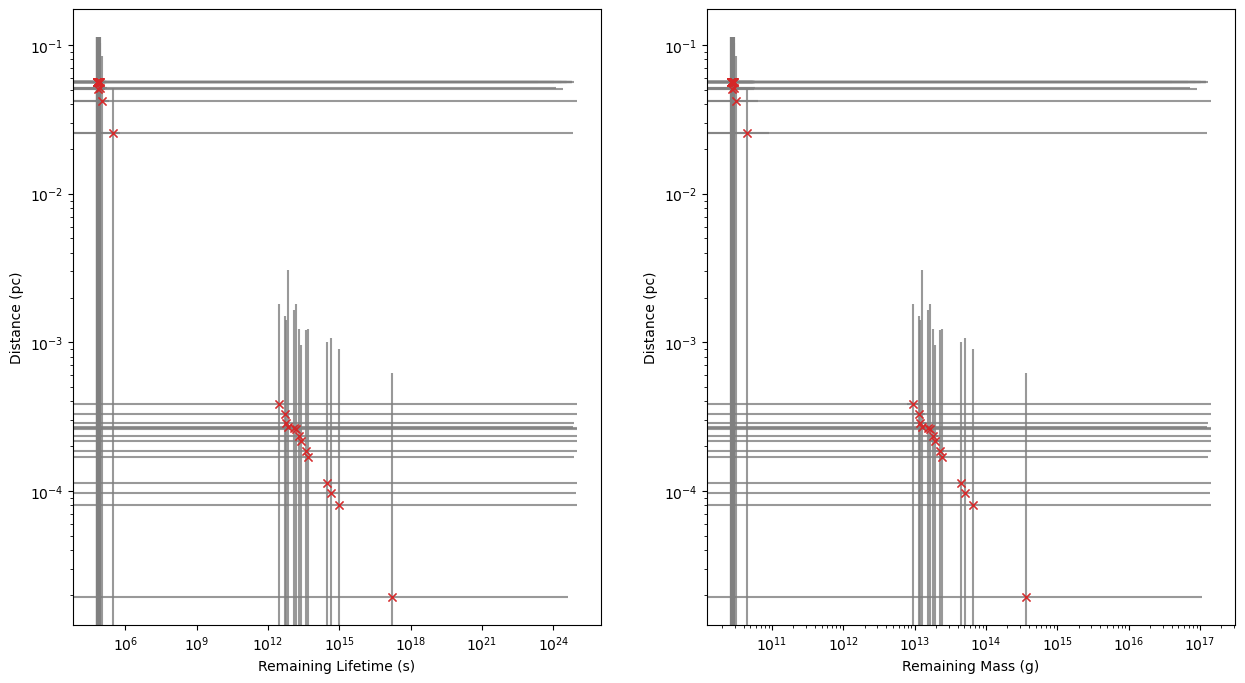

In [90]:
fig, axes = plt.subplots(1,2, figsize = (15,8))

ax = axes[0]
for key in fit_results:
    A, T0 = fit_results[key]['Coefs']
    # A_std, T0_std = np.sqrt(np.diagonal(fit_results[key]['Cov']))
    A_std = T0_std = fit_results[key]['Serr']

    d = distance_A(A)
    d_std = distance_A(A_std)
    ax.errorbar(x = seconds_in_a_day*[T0,T0], xerr = seconds_in_a_day*[ fit_results[key]['T0_min'], fit_results[key]['T0_max'] ],
        y = [d,d], yerr = [ distance_A(fit_results[key]['A_min']), distance_A(fit_results[key]['A_max']) ],
        fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.8, zorder = 1)
    # ax.plot(T0, d, 'x', color='C3', markeredgecolor = 'C3', alpha=.8, zorder = 1)


# ax.set_xlabel('Norm (1/pc^2)')
ax.set_ylabel('Distance (pc)')
ax.set_xlabel('Remaining Lifetime (s)')
ax.set_yscale('log')
ax.set_xscale('log')

lim = lambda X,Y: (4*3.14159/3) * (3400) / ( X**3 ) / (Y*3e-7)


###########
ax = axes[1]
for key in fit_results:
    A, T0 = fit_results[key]['Coefs']
    # A_std, T0_std = np.sqrt(np.diagonal(fit_results[key]['Cov']))
    A_std = T0_std = 10**fit_results[key]['Serr']

    d = distance_A(A)
    d_std = distance_A(A_std)

    mass = remaining_mass(seconds_in_a_day*T0)
    ax.errorbar(x = [mass,mass], xerr = seconds_in_a_day*[ remaining_mass(fit_results[key]['T0_min']), remaining_mass(fit_results[key]['T0_max']) ], 
        y = [d,d], yerr = [ distance_A(fit_results[key]['A_min']), distance_A(fit_results[key]['A_max']) ], 
        fmt = 'x', color='grey', markeredgecolor = 'C3', alpha=.8, zorder = 1)
    # ax.plot(mass, d, 'x', color='C3', markeredgecolor = 'C3', alpha=.8, zorder = 1)

ax.set_ylabel('Distance (pc)')
ax.set_xlabel('Remaining Mass (g)')
ax.set_yscale('log')
ax.set_xscale('log')


fig.savefig('TransientsDistribution.png')